In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from matplotlib.lines import Line2D
import qinfer as qi
from scipy import linalg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.markers as mmark
from matplotlib.ticker import PercentFormatter

from lfig import LatexFigure
sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline

In [2]:
def load_results(
    results_time,
    results_folder=os.path.abspath("/home/bf16951/thesis/qmla_run_data/"),
    run_id='001'
):

    results_dir = os.path.join(
        results_folder, 
        results_time
    )

    try:
        results_file = os.path.join(results_dir, 'results_{}.p'.format(run_id))
        res = pickle.load(open(results_file, 'rb'))
    except:
        results_file = os.path.join(results_dir, 'results_m1_q{}.p'.format(run_id))
        res = pickle.load(open(results_file, 'rb'))


    true_params = pickle.load(open(os.path.join(results_dir, 'run_info.p'), 'rb')) 
    qmla_class_file = os.path.join(results_dir, 'qmla_class_{}.p'.format(run_id))
    plot_probes = pickle.load(open(os.path.join(results_dir, 'plot_probes.p'), 'rb'))
    true_measurements = pickle.load(open(os.path.join(results_dir, 'system_measurements.p'), 'rb'))
    q = pickle.load(open(qmla_class_file, 'rb'))
    try:
        q2 = pickle.load(open(os.path.join(results_dir, 'qmd_class_002.p'), 'rb'))
    except:
        pass
    es = q.exploration_class
    try:
        combined_datasets = os.path.join(results_dir, 'combined_datasets')
        evaluation_data = pickle.load(open(os.path.join(results_dir, 'evaluation_data.p' ), 'rb'))
        storage = pickle.load(open(os.path.join(results_dir, 'storage_{}.p'.format(run_id)), 'rb'))
        system_probes = pickle.load(open(
            os.path.join(results_dir, 'training_probes', 'system_probes.p'),
            'rb'
        ))
        ga = gr.genetic_algorithm
    except:
        pass

    try:
        # these are only available if analysis has been performed
        champ_info = pickle.load(open(os.path.join(results_dir, 'champion_models',  'champions_info.p' ), 'rb'))
        bf = pd.read_csv(os.path.join(combined_datasets,  'bayes_factors.csv' ))
        fitness_df = pd.read_csv(os.path.join(combined_datasets,  'fitness_df.csv' ))
        combined_results = pd.read_csv(os.path.join(results_dir, 'combined_results.csv'))
        correlations = pd.read_csv(
            os.path.join(combined_datasets, "fitness_correlations.csv")
        )
        fitness_by_f_score = pd.read_csv(
            os.path.join(combined_datasets, 'fitness_by_f_score.csv')
        )
    except:
        pass
    
    results = {
        'qmla_instance' : q, 
        'exploration_strategy' : es, 
        'results_dir' : results_dir,
        'true_measurements' : true_measurements, 
        'true_params' : true_params
    }
    
    return results

# 2 parameter Ising

In [3]:
def offline_plot_learning_summary(
    mod, 
    save_to_file, 
    param_order=None, 
    lf_fraction=1, 
    param_legend="inside"
):
    r"""
    Modified from _plot_learning_summary within ModelForLearning. 
    """

    if param_order is None:
        terms = mod.track_param_estimate_v_epoch.keys()
    else:
        terms = param_order
    
    num_terms = len(terms)

    extra_plots = [
        'volume', 
        # 'quad_loss',  'residuals', 'likelihoods'
    ]
    resample_colour = 'grey'

    ncols = int(np.ceil(np.sqrt(num_terms)))
    nrows_for_params = int(np.ceil(num_terms / ncols))
    nrows = nrows_for_params + len(extra_plots)
    height_ratios = [1]*nrows_for_params
    height_ratios.extend([ncols*0.7]*len(extra_plots))
    plt.clf()
    lf = LatexFigure(
        fraction=lf_fraction,
        use_gridspec=True, 
        gridspec_layout=(nrows, ncols),
        gridspec_params={'height_ratios' : height_ratios}
    )

    # Parameter estimates
    for term in terms:
        ax = lf.new_axis(
#             label_position=(-.3, 1.1)
        )
        estimates = mod.track_param_estimate_v_epoch[term]
        uncertainty = mod.track_param_uncertainty_v_epoch[term]
        lower_bound = estimates - uncertainty
        upper_bound = estimates + uncertainty

        epochs = range(len(estimates))

        ax.plot(epochs, estimates, label='Estimate')
        ax.fill_between(
            epochs,
            lower_bound,
            upper_bound,
            alpha=0.2,
#             label='Uncertainty'
        )

        if term in q.true_param_dict:
            true_param = q.true_param_dict[term]
            ax.axhline(true_param, color='red', ls='--', label='True')

        try:
            term_latex = mod.exploration_class.latex_name(term)
            ax.set_title(term_latex)
            # ax.set_ylabel(term_latex)
        except BaseException:
            mod.log_print(["Failed to get latex name"])
            raise
        # ax.set_ylabel('Parameter')
        ax.set_xlabel('Epoch')

        if ax.row == 0 and ax.col == lf.gridspec_layout[1]-1:
            if param_legend == "outside":
                ax.legend(
                    bbox_to_anchor=(1.25, 1.1)
                )
            else: 
                ax.legend(
                    loc = 'upper right'
                )
                
    if 'volume' in extra_plots:
        # Volume and experimental times
        ax = lf.new_axis(
#             label_position=(-0.1, 1.05),
            span=(1, 'all')
        )

        exps = sorted(model.volume_by_epoch.keys())
        ax.plot(
            exps,
            [model.volume_by_epoch[k] for k in exps],
            label=r"$V$",
            color='k'
        )

        ax.set_ylabel('Volume')
        ax.set_xlabel('Epoch')
        ax.set_yscale('log')

        time_ax = ax.twinx()
        times = qmla.utilities.flatten(mod.times_learned_over)
        if q.num_experiments > 100:
            s = 4  # size of time dots
        else:
            s = 7
        time_ax.scatter(
            exps[1:],
            times,
            label=r"$t$",
            s=s,
        )
        time_ax.set_ylabel('Time')
        time_ax.semilogy()
        
        handles, labels = ax.get_legend_handles_labels()
        t_handles, t_labels = time_ax.get_legend_handles_labels()
        handles.extend(t_handles)
        labels.extend(t_labels)

        ax.legend(
            handles, labels, 
            ncol=2, 
            loc='upper center'
            # bbox_to_anchor=(0.4, 1.25)
        )

    lf.fig.tight_layout()
    lf.save(save_to_file)

In [4]:
results = load_results("Nov_18/13_56")
q = results['qmla_instance']
q.true_param_dict.update({
    "pauliSet_x_1_d3" : 0.2, 
    "pauliSet_x_2_d3" : 0.2, 
    "pauliSet_x_3_d3" : 0.2, 
    "pauliSet_zJz_1J2_d3" : 0.8, 
    "pauliSet_zJz_1J3_d3" : 0.8,
    "pauliSet_zJz_2J3_d3" : 0.8
})
es = results['exploration_strategy']
results_dir = results['results_dir']

/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


<Figure size 640x480 with 0 Axes>

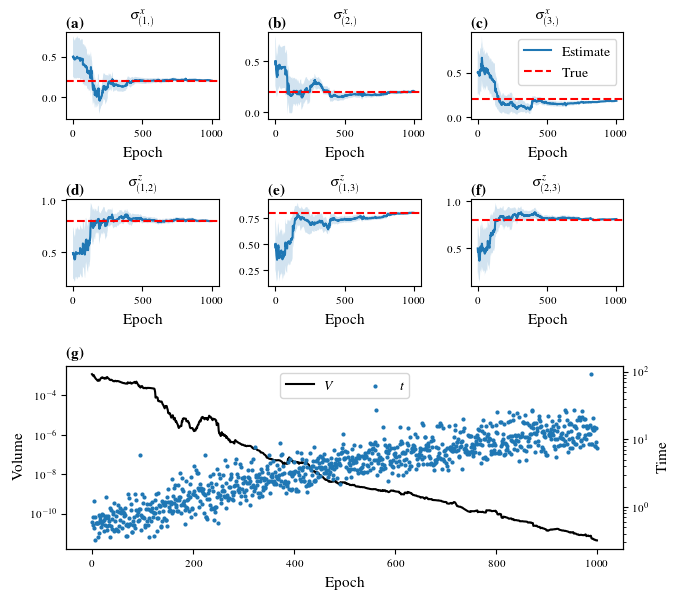

In [36]:
# Note: first ensure the legend for parameters is outside
# set within offline_plot_learning_summary

model = q.get_model_storage_instance_by_id(1)

param_order = [
    "pauliSet_x_1_d3" ,
    "pauliSet_x_2_d3",
    "pauliSet_x_3_d3" ,
    "pauliSet_zJz_1J2_d3" ,
    "pauliSet_zJz_1J3_d3" ,
    "pauliSet_zJz_2J3_d3" ,
]

save_path = os.path.join(
    results_dir, 
    "fully_param_ising_qhl.pdf"
)

offline_plot_learning_summary(
    model, 
    save_path,
    param_order = param_order,
#     lf_fraction = 0.75, 
#     param_legend="outside"
)

# Fully parameterised Ising

In [6]:
es.latex_model_naming_function

<function qmla.shared_functionality.latex_model_names.lattice_pauli_likewise_concise>

/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


<Figure size 640x480 with 0 Axes>

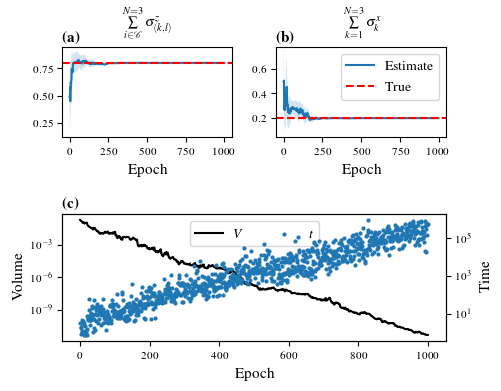

In [7]:
model = q.get_model_storage_instance_by_id(2)

save_path = os.path.join(
    results_dir, 
    "standard_ising_qhl.pdf"
)

offline_plot_learning_summary(
    model, 
    save_path,
    lf_fraction = 0.75, 
#     param_order = param_order ,
#     param_legend="outside"
)

# Plot dynamics of both models

/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


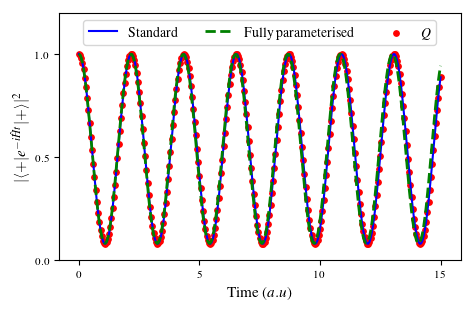

In [50]:
times = sorted(results['true_measurements'].keys())
msmts = [results['true_measurements'][t] for t in times]

lf = LatexFigure(fraction=0.75)
ax = lf.new_axis(auto_label=False)
times = sorted(model.expectation_values.keys())

std_model = q.get_model_storage_instance_by_id(2)
fully_param_model = q.get_model_storage_instance_by_id(1)

ax.plot(
    times, 
    [std_model.expectation_values[t] for t in times],
    c = 'blue',
    label = 'Standard'
)
ax.plot(
    times, 
    [fully_param_model.expectation_values[t] for t in times],
    c = 'green',
    ls = '--',
    lw = 2, 
    label = 'Fully parameterised'
)

ax.scatter(
    times, 
    msmts, 
    c = 'red',
    s = 15, 
    label='$Q$'
)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel(r"$| \langle + | e^{-i\hat{H}t} | + \rangle |^2$")
ax.set_xlabel(r"Time ($a.u$)")
ax.set_xticks([0, 5, 10, 15])
ax.legend(ncol=3, loc = 'upper center')

save_path = os.path.join(
    results_dir, 
    "dynamics.pdf"
)
lf.save(save_path)

